In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 10 18:33:54 2025

@author: rjsyo
"""

import pandas as pd

prices1 = pd.read_csv("./prices_round_3_day_0.csv", sep=';', header=0)
prices2 = pd.read_csv("./prices_round_3_day_1.csv", sep=';', header=0)
prices3 = pd.read_csv("./prices_round_3_day_2.csv", sep=';', header=0)

prices2['timestamp'] = prices2['timestamp'] + 1000000
prices3['timestamp'] = prices3['timestamp'] + 2000000

price_df = pd.concat([prices1, prices2, prices3], ignore_index=True)

day = 0
#price_df = prices1

items = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2']
baskets = ['PICNIC_BASKET1', 'PICNIC_BASKET2']

weights = {
    'PICNIC_BASKET1': {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1},
    'PICNIC_BASKET2': {'CROISSANTS': 4, 'JAMS': 2, 'DJEMBES': 0},
    'SYNTHETIC_BASKET': {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 0},
    'SYNTHETIC_BASKET_2': {'CROISSANTS': 0, 'JAMS': 0, 'DJEMBES': 1}
}


def get_vwmp(row):
    best_bid = row['bid_price_1']
    best_ask = row['ask_price_1']
    bid_volume = row['bid_volume_1']
    ask_volume = row['ask_volume_1']

    return (best_bid * ask_volume + best_ask * bid_volume)/(bid_volume + ask_volume)

def mm_mid_basket(row, volume_cutoff=10):
    last_volume = 0
    for i in range(1,4):
        if row[f'bid_volume_{i}'] + last_volume >= volume_cutoff:
            best_bid = row[f'bid_price_{i}']
            break
        else:
            last_volume += 0#row[f'bid_volume_{i}']
    else:
        best_bid = None


    for i in range(1,4):
        if row[f'ask_volume_{i}'] + last_volume >= volume_cutoff:
            best_ask = row[f'ask_price_{i}']
            break
        else:
            last_volume += 0#row[f'ask_volume_{i}']
    else:
        best_ask = None

    if best_bid is not None and best_ask is not None:
        mid_price = (best_bid + best_ask) / 2
        return mid_price
    else:
        return row['mid_price']

def fair_price(row):
    if row['product'] in baskets:
        return mm_mid_basket(row, volume_cutoff=10)
    else:
        return get_vwmp(row)

price_df['fair'] = price_df.apply(fair_price, axis=1)
products = price_df['product'].unique()

columns = ['timestamp'] + list(products)
df_fairs = pd.DataFrame(columns=columns)

for timestamp in price_df['timestamp'].unique():
    rows = price_df[price_df['timestamp'] == timestamp]

    fairs = {}

    for product in products:
        fair = rows.loc[rows['product'] == product, 'fair'].values[0]
        fairs[product] = fair

    synthetic_fair1 = sum(fairs[product] * weights['PICNIC_BASKET1'].get(product, 0) for product in products)
    synthetic_fair2 = sum(fairs[product] * weights['PICNIC_BASKET2'].get(product, 0) for product in products)
    synthetic_fair3 = sum(fairs[product] * weights['SYNTHETIC_BASKET'].get(product, 0) for product in products)
    synthetic_fair4 = sum(fairs[product] * weights['SYNTHETIC_BASKET_2'].get(product, 0) for product in products)

    new_row = pd.DataFrame({'timestamp': [timestamp], **{product: [fairs[product]] for product in products}, 'SYNTHETIC_1': [synthetic_fair1], 'SYNTHETIC_2': [synthetic_fair2], 'SYNTHETIC_3': [synthetic_fair3], 'SYNTHETIC_4': [synthetic_fair4]})
    df_fairs = pd.concat([df_fairs, new_row], ignore_index=True)

df_fairs = df_fairs.reset_index(drop=True)


<ipython-input-71-3dcccc44bde0>:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fairs = pd.concat([df_fairs, new_row], ignore_index=True)


In [ ]:
df_fairs

,timestamp,CROISSANTS,JAMS,SQUID_INK,PICNIC_BASKET1,PICNIC_BASKET2,RAINFOREST_RESIN,DJEMBES,KELP,SYNTHETIC_1,SYNTHETIC_2,SYNTHETIC_3,SYNTHETIC_4
0,0,4304.500000,6670.500000,2005.031250,59289.5,30609.0,10002.666667,13450.500000,2028.031250,59289.000000,30559.000000,45838.500000,13450.500000
1,100,4304.500000,6670.500000,2005.500000,59287.5,30613.0,10000.000000,13450.000000,2027.769231,59288.500000,30559.000000,45838.500000,13450.000000
2,200,4304.500000,6671.000000,2004.571429,59293.5,30615.0,10000.000000,13450.281690,2026.571429,59290.281690,30560.000000,45840.000000,13450.281690
3,300,4304.500000,6672.000000,2004.500000,59293.5,30620.0,10000.000000,13450.000000,2027.818182,59293.000000,30562.000000,45843.000000,13450.000000
4,400,4305.500000,6672.000000,2005.500000,59294.5,30622.0,10000.000000,13452.500000,2026.500000,59301.500000,30566.000000,45849.000000,13452.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,4268.500000,6519.991667,1802.038462,58720.5,30118.0,10002.000000,13418.274725,2046.038462,58589.249725,30113.983333,45170.975000,13418.274725
29996,2999600,4268.500000,6519.500000,1801.153846,58719.5,30115.0,10000.000000,13417.674419,2046.076923,58587.174419,30113.000000,45169.500000,13417.674419
29997,2999700,4268.500000,6519.500000,1801.474576,58717.5,30113.0,9996.750000,13418.000000,2045.474576,58587.500000,30113.000000,45169.500000,13418.000000
29998,2999800,4268.256098,6520.000000,1801.500000,58725.5,30112.0,10000.000000,13418.000000,2045.500000,58587.536585,30113.024390,45169.536585,13418.000000


In [ ]:
df_fairs = df_fairs[['timestamp', 'CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2', 'SYNTHETIC_1', 'SYNTHETIC_2', 'SYNTHETIC_3', 'SYNTHETIC_4']]

In [ ]:
df_fairs['SPREAD_1'] = df_fairs['PICNIC_BASKET1'] - df_fairs['SYNTHETIC_1']
df_fairs['SPREAD_2'] = df_fairs['PICNIC_BASKET2'] - df_fairs['SYNTHETIC_2']
df_fairs['SPREAD_3'] = df_fairs['SYNTHETIC_3'] - df_fairs['SYNTHETIC_1']
df_fairs['SPREAD_4'] = df_fairs['PICNIC_BASKET1'] - df_fairs['CROISSANTS']*6 - df_fairs['JAMS']*3 - df_fairs['DJEMBES']
df_fairs['SPREAD_DIFF_1'] = 2 * df_fairs['SPREAD_1'] - 3 * df_fairs['SPREAD_2']
df_fairs['SPREAD_DIFF_2'] = 2 * df_fairs['SPREAD_1'] - 3 * df_fairs['SPREAD_2']

In [ ]:
df_fairs

,timestamp,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1,PICNIC_BASKET2,SYNTHETIC_1,SYNTHETIC_2,SYNTHETIC_3,SYNTHETIC_4,SPREAD_1,SPREAD_2,SPREAD_3,SPREAD_4,SPREAD_DIFF_1,SPREAD_DIFF_2
0,0,4304.500000,6670.500000,13450.500000,59289.5,30609.0,59289.000000,30559.000000,45838.500000,13450.500000,0.500000,50.000000,-13450.500000,0.500000,-149.000000,-149.000000
1,100,4304.500000,6670.500000,13450.000000,59287.5,30613.0,59288.500000,30559.000000,45838.500000,13450.000000,-1.000000,54.000000,-13450.000000,-1.000000,-164.000000,-164.000000
2,200,4304.500000,6671.000000,13450.281690,59293.5,30615.0,59290.281690,30560.000000,45840.000000,13450.281690,3.218310,55.000000,-13450.281690,3.218310,-158.563380,-158.563380
3,300,4304.500000,6672.000000,13450.000000,59293.5,30620.0,59293.000000,30562.000000,45843.000000,13450.000000,0.500000,58.000000,-13450.000000,0.500000,-173.000000,-173.000000
4,400,4305.500000,6672.000000,13452.500000,59294.5,30622.0,59301.500000,30566.000000,45849.000000,13452.500000,-7.000000,56.000000,-13452.500000,-7.000000,-182.000000,-182.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,4268.500000,6519.991667,13418.274725,58720.5,30118.0,58589.249725,30113.983333,45170.975000,13418.274725,131.250275,4.016667,-13418.274725,131.250275,250.450549,250.450549
29996,2999600,4268.500000,6519.500000,13417.674419,58719.5,30115.0,58587.174419,30113.000000,45169.500000,13417.674419,132.325581,2.000000,-13417.674419,132.325581,258.651163,258.651163
29997,2999700,4268.500000,6519.500000,13418.000000,58717.5,30113.0,58587.500000,30113.000000,45169.500000,13418.000000,130.000000,0.000000,-13418.000000,130.000000,260.000000,260.000000
29998,2999800,4268.256098,6520.000000,13418.000000,58725.5,30112.0,58587.536585,30113.024390,45169.536585,13418.000000,137.963415,-1.024390,-13418.000000,137.963415,279.000000,279.000000


In [ ]:
true_mean1 = df_fairs['SPREAD_1'].mean()
true_mean2 = df_fairs['SPREAD_2'].mean()
true_mean3 = df_fairs['SPREAD_3'].mean()
true_mean4 = df_fairs['SPREAD_4'].mean()
djembe_mean = df_fairs['DJEMBES'].mean()
spread_diff_1_mean = df_fairs['SPREAD_DIFF_1'].mean()
spread_diff_2_mean = df_fairs['SPREAD_DIFF_2'].mean()
print(f"True mean1: {true_mean1}")
print(f"True mean2: {true_mean2}")
print(f"True mean3: {true_mean3}")
print(f"True mean4: {true_mean4}")
print(f"Djembe mean: {djembe_mean}")
print(f"Spread diff1 mean: {spread_diff_1_mean}")
print(f"Spread diff2 mean: {spread_diff_2_mean}")

True mean1: 57.684812242529304
True mean2: 22.579443653884393
True mean3: -13396.357009834608
True mean4: 57.62980247657382
Djembe mean: 13396.30507475247
Spread diff1 mean: 47.63129352340542
Spread diff2 mean: 47.63129352340542


,SPREAD_SQUID_INK_RETURNS
0,NaN
1,0.000234
2,-0.000463
3,-0.000036
4,0.000499
...,...
29995,0.000299
29996,-0.000491
29997,0.000178
29998,0.000014


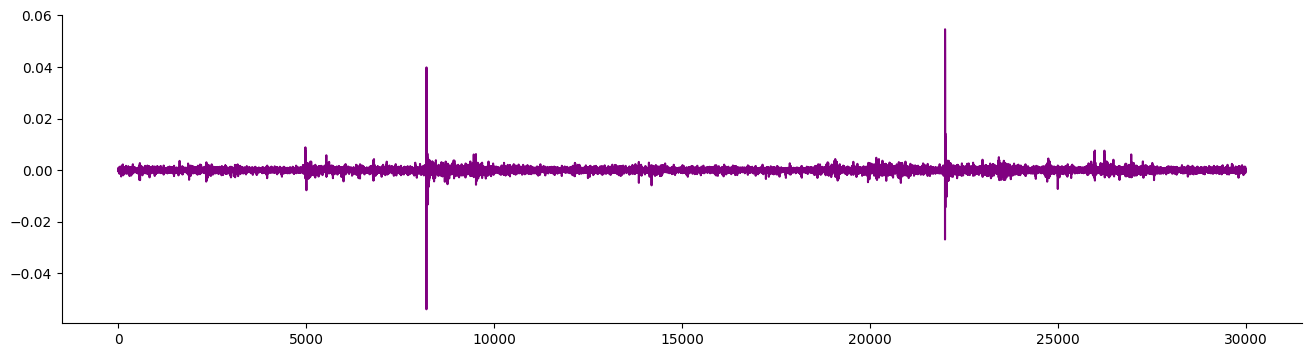

In [ ]:
# @title Spreads

from matplotlib import pyplot as plt
"""
df_fairs['SPREAD_1'].plot(kind='line', figsize=(16, 4), title='', color='green')
plt.gca().spines[['top', 'right']].set_visible(False)
df_fairs['SPREAD_2'].plot(kind='line', figsize=(16, 4), title='', color='blue')
plt.gca().spines[['top', 'right']].set_visible(False)
#df_fairs['SPREAD_DIFF_1'].plot(kind='line', figsize=(16, 4), title='SPREADS', color='orange')
plt.gca().spines[['top', 'right']].set_visible(False)
(df_fairs['SPREAD_DIFF_1']).plot(kind='line', figsize=(16, 4), title='', color='red')
plt.gca().spines[['top', 'right']].set_visible(False)
(df_fairs['SPREAD_DIFF_2']).plot(kind='line', figsize=(16, 4), title='', color='purple')
plt.gca().spines[['top', 'right']].set_visible(False)
"""
df_fairs['SPREAD_SQUID_INK_RETURNS'] = df_fairs['SQUID_INK'].pct_change()
(df_fairs['SPREAD_SQUID_INK_RETURNS']).plot(kind='line', figsize=(16, 4), title='', color='purple')
plt.gca().spines[['top', 'right']].set_visible(False)


In [ ]:
#@title spread analysis

import itertools
products1 = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2', 'SYNTHETIC_1', 'SYNTHETIC_2', 'SYNTHETIC_3']
products2 = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2', 'SYNTHETIC_1', 'SYNTHETIC_2', 'SYNTHETIC_3']

common = set(products1) & set(products2)
pairs = list(itertools.combinations(common, 2))

results = []
for pair in itertools.product(pairs):
  product1 = pair[0][0]
  product2 = pair[0][1]

  results.append({
        'product1': product1,
        'product2': product2,
        'spread_mean': (df_fairs[product1].mean() - df_fairs[product2].mean()),
        'spread_std': (df_fairs[product1] - df_fairs[product2]).std()
    })

results = pd.DataFrame(results)
results = results.sort_values(by='spread_std', ascending=True)
results
D_C_MEAN = 9138.39

nan nan


In [ ]:
def boll(data, spread_num, window, num_std, recent_vol=0, vol_window=0):
  data['SMA'] = data["SPREAD_"+spread_num].rolling(window=window).mean()
  data['STD'] = data["SPREAD_"+spread_num].rolling(window=window).std()

  if recent_vol != 0 and vol_window != 0:
    data['RECENT_STD'] = data["SPREAD_"+spread_num].rolling(window=vol_window).std()
    num_std *= recent_vol * data['RECENT_STD']/data['STD']

  data['UPPER_BAND_'+spread_num] = data['SMA'] + (data['STD']*num_std)
  data['LOWER_BAND_'+spread_num] = data['SMA'] - (data['STD']*num_std)


  return data

In [ ]:
#df_fairs = boll(df_fairs, spread_num="DIFF_1", window=100, num_std=1)
#df_fairs = boll(df_fairs, spread_num="DIFF_2", window=100, num_std=2.5)
#df_fairs = boll(df_fairs, spread_num="1", window=50, num_std=1.5)
#df_fairs = boll(df_fairs, spread_num="2", window=50, num_std=1.5)
df_fairs = boll(df_fairs, spread_num="1", window=100, num_std=1.5, recent_vol=2, vol_window=45)
df_fairs
#df_fairs['STD_CHANGE'] = df_fairs['STD'].diff()

,timestamp,VOLCANIC_ROCK_VOUCHER_10500,DJEMBES,CROISSANTS,JAMS,VOLCANIC_ROCK_VOUCHER_10000,KELP,VOLCANIC_ROCK_VOUCHER_9750,PICNIC_BASKET1,PICNIC_BASKET2,...,SPREAD_2,SPREAD_3,SPREAD_4,SPREAD_DIFF_1,SPREAD_DIFF_2,SMA,STD,RECENT_STD,UPPER_BAND_1,LOWER_BAND_1
0,0,99.5,13493.500000,4321.500000,6632.0,505.5,2030.000000,754.5,59228.5,30505.0,...,-45.000000,-13493.500000,-90.000000,-45.000000,-45.000000,NaN,NaN,NaN,NaN,NaN
1,100,102.5,13493.000000,4321.738693,6631.5,515.5,2030.228571,761.5,59228.5,30504.0,...,-45.954774,-13493.000000,-89.432161,-41.000000,-41.000000,NaN,NaN,NaN,NaN,NaN
2,200,104.5,13493.256098,4321.741463,6632.0,516.5,2029.130435,764.5,59232.0,30505.0,...,-45.965854,-13493.256098,-87.704878,-37.512195,-37.512195,NaN,NaN,NaN,NaN,NaN
3,300,106.5,13493.295918,4321.500000,6632.0,521.5,2030.500000,768.5,59228.5,30501.5,...,-48.500000,-13493.295918,-89.795918,-34.091837,-34.091837,NaN,NaN,NaN,NaN,NaN
4,400,102.5,13493.287356,4321.500000,6632.0,512.5,2029.250000,760.5,59230.5,30505.5,...,-44.500000,-13493.287356,-87.787356,-42.074713,-42.074713,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,3.2,13296.500000,4239.500000,6526.0,182.2,2041.600000,418.2,58410.5,30073.0,...,63.000000,-13296.500000,99.000000,9.000000,9.000000,NaN,NaN,NaN,NaN,NaN
29996,2999600,3.5,13295.697368,4239.500000,6526.0,184.5,2041.714286,418.5,58415.5,30069.0,...,59.000000,-13295.697368,104.802632,32.605263,32.605263,NaN,NaN,NaN,NaN,NaN
29997,2999700,3.5,13295.500000,4239.500000,6526.0,182.5,2041.500000,418.5,58415.0,30069.0,...,59.000000,-13295.500000,104.500000,32.000000,32.000000,NaN,NaN,NaN,NaN,NaN
29998,2999800,3.5,13296.263736,4240.254438,6526.0,185.5,2041.500000,418.5,58420.5,30072.0,...,58.982249,-13296.263736,104.709637,32.472527,32.472527,NaN,NaN,NaN,NaN,NaN


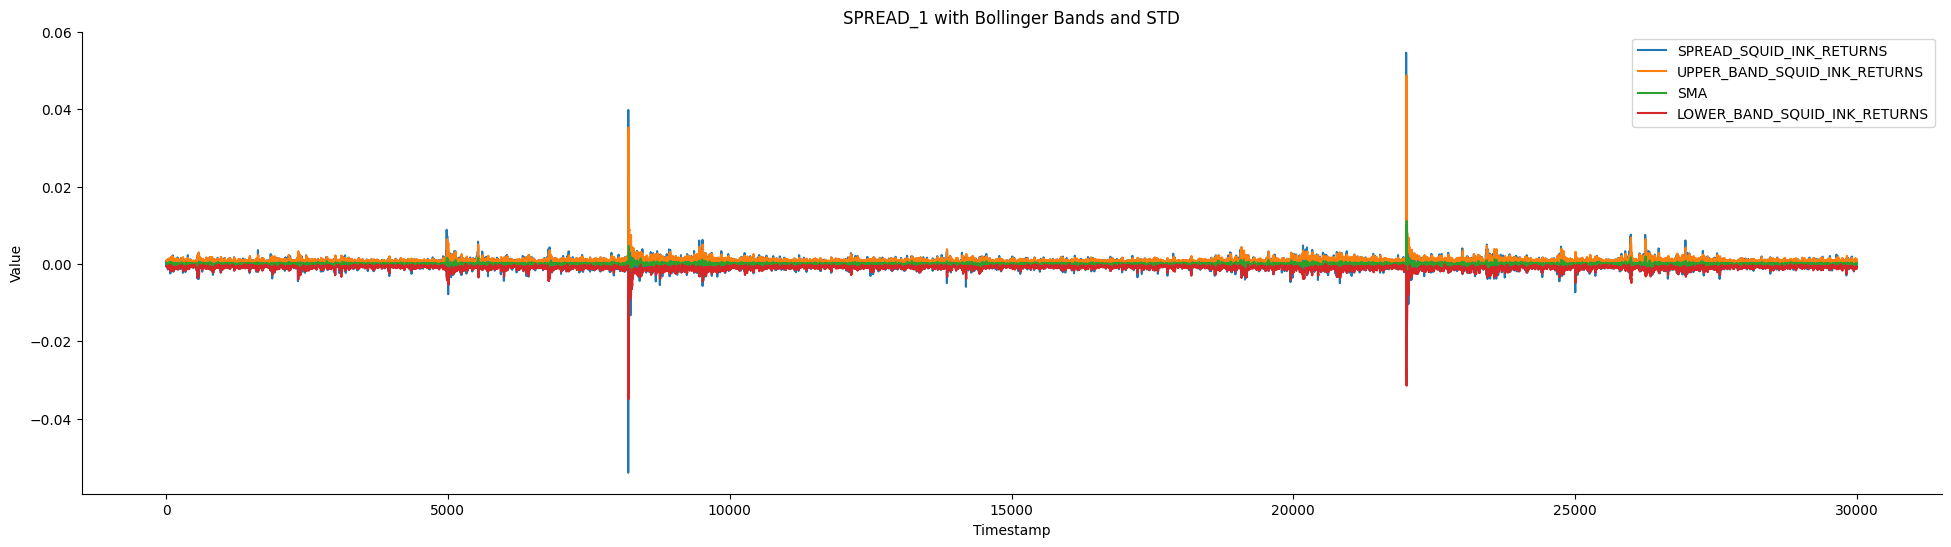

In [ ]:
# prompt: graph df_fairs with a line for: SPREAD_1, UPPER_BAND, SMA, LOWER_BAND, and STD

import matplotlib.pyplot as plt
# Plot the specified columns
df_fairs[['SPREAD_SQUID_INK_RETURNS', 'UPPER_BAND_SQUID_INK_RETURNS', 'SMA', 'LOWER_BAND_SQUID_INK_RETURNS']].plot(figsize=(24, 6))
plt.title('SPREAD_1 with Bollinger Bands and STD')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


In [ ]:
def identify_regime(data, spread_num, mean, lookback, ema=0):
  price = data['SPREAD_'+spread_num]
  if ema != 0:
    price = data['SPREAD_'+spread_num].ewm(halflife=ema).mean()
  upper = data['UPPER_BAND_'+spread_num]
  lower = data['LOWER_BAND_'+spread_num]

  rolling_window = price.rolling(window=lookback)

  above_upper = (price >= upper).rolling(window=lookback).sum()
  below_lower = (price <= lower).rolling(window=lookback).sum()

  touched_upper = (above_upper > 1).astype(int)
  touched_lower = (below_lower > 1).astype(int)

  regimes = pd.Series(index=data.index, dtype='object')
  regimes.loc[(touched_upper == 1) & (touched_lower == 1)] = 'OSCILLATING'
  regimes.loc[(touched_upper == 1) & (touched_lower == 0)] = 'UPPER'
  regimes.loc[(touched_upper == 0) & (touched_lower == 1)] = 'LOWER'
  regimes.iloc[:lookback] = 'NEUTRAL'

  return regimes

#df_fairs['REGIME_DIFF_1'] = identify_regime(df_fairs, 'DIFF_1', 0, 100, ema=0)
#f_fairs['REGIME_DIFF_2'] = identify_regime(df_fairs, 'DIFF_2', 0, 100, ema=2)
#df_fairs['REGIME_1'] = identify_regime(df_fairs, '1', true_mean1, 50, ema=0)
#df_fairs['REGIME_2'] = identify_regime(df_fairs, '2', true_mean2, 50, ema=0)
df_fairs['REGIME_1'] = identify_regime(df_fairs, '1', 0, 100, ema=5)
df_fairs

,timestamp,VOLCANIC_ROCK_VOUCHER_10500,DJEMBES,CROISSANTS,JAMS,VOLCANIC_ROCK_VOUCHER_10000,KELP,VOLCANIC_ROCK_VOUCHER_9750,PICNIC_BASKET1,PICNIC_BASKET2,...,SPREAD_3,SPREAD_4,SPREAD_DIFF_1,SPREAD_DIFF_2,SMA,STD,RECENT_STD,UPPER_BAND_1,LOWER_BAND_1,REGIME_1
0,0,99.5,13493.500000,4321.500000,6632.0,505.5,2030.000000,754.5,59228.5,30505.0,...,-13493.500000,-90.000000,-45.000000,-45.000000,NaN,NaN,NaN,NaN,NaN,NEUTRAL
1,100,102.5,13493.000000,4321.738693,6631.5,515.5,2030.228571,761.5,59228.5,30504.0,...,-13493.000000,-89.432161,-41.000000,-41.000000,NaN,NaN,NaN,NaN,NaN,NEUTRAL
2,200,104.5,13493.256098,4321.741463,6632.0,516.5,2029.130435,764.5,59232.0,30505.0,...,-13493.256098,-87.704878,-37.512195,-37.512195,NaN,NaN,NaN,NaN,NaN,NEUTRAL
3,300,106.5,13493.295918,4321.500000,6632.0,521.5,2030.500000,768.5,59228.5,30501.5,...,-13493.295918,-89.795918,-34.091837,-34.091837,NaN,NaN,NaN,NaN,NaN,NEUTRAL
4,400,102.5,13493.287356,4321.500000,6632.0,512.5,2029.250000,760.5,59230.5,30505.5,...,-13493.287356,-87.787356,-42.074713,-42.074713,NaN,NaN,NaN,NaN,NaN,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,3.2,13296.500000,4239.500000,6526.0,182.2,2041.600000,418.2,58410.5,30073.0,...,-13296.500000,99.000000,9.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN
29996,2999600,3.5,13295.697368,4239.500000,6526.0,184.5,2041.714286,418.5,58415.5,30069.0,...,-13295.697368,104.802632,32.605263,32.605263,NaN,NaN,NaN,NaN,NaN,NaN
29997,2999700,3.5,13295.500000,4239.500000,6526.0,182.5,2041.500000,418.5,58415.0,30069.0,...,-13295.500000,104.500000,32.000000,32.000000,NaN,NaN,NaN,NaN,NaN,NaN
29998,2999800,3.5,13296.263736,4240.254438,6526.0,185.5,2041.500000,418.5,58420.5,30072.0,...,-13296.263736,104.709637,32.472527,32.472527,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from tqdm import tqdm
def generate_signals(data, mean_price, spread_num, strict = False):
  price = data['SPREAD_'+spread_num]
  upper = data['UPPER_BAND_'+spread_num]
  lower = data['LOWER_BAND_'+spread_num]
  regime = data['REGIME_'+spread_num]

  signals = pd.Series(index=data.index, dtype='object')


  for i in tqdm(range(1, len(data))):
    if strict:
            upper_req = price[i] > mean_price
            lower_req = price[i] < mean_price
    else:
        upper_req = True
        lower_req = True

    if regime.iloc[i] == 'OSCILLATING':
       if price[i] >= upper[i] and price[i-1] < upper[i-1] and upper_req:
          signals.iloc[i] = 'SELL'
       elif price[i] <= lower[i] and price[i-1] > lower[i-1] and lower_req:
          signals.iloc[i] = 'BUY'
    elif regime.iloc[i] == 'UPPER':
      if price[i] > mean_price:
        signals.iloc[i] = 'CLEAR'
      else:
        signals.iloc[i] = 'BUY'
    elif regime.iloc[i] == 'LOWER':
      if price[i] < mean_price:
        signals.iloc[i] = 'CLEAR'
      else:
        signals.iloc[i] = 'SELL'
    elif regime.iloc[i] == 'NEUTRAL':
      signals.iloc[i] = 'CLEAR'

  return signals

#df_fairs['SIGNAL_DIFF_1'] = generate_signals(df_fairs, 0, 'DIFF_1')
#df_fairs['SIGNAL_DIFF_2'] = generate_signals(df_fairs, 0, 'DIFF_2')
#df_fairs['SIGNAL_1'] = generate_signals(df_fairs, true_mean1, '1')
#df_fairs['SIGNAL_2'] = generate_signals(df_fairs, true_mean2, '2')
df_fairs['SIGNAL_1'] = generate_signals(df_fairs, 50, '1', strict=True)
df_fairs

100%|██████████| 29999/29999 [00:00<00:00, 41774.42it/s]


,timestamp,VOLCANIC_ROCK_VOUCHER_10500,DJEMBES,CROISSANTS,JAMS,VOLCANIC_ROCK_VOUCHER_10000,KELP,VOLCANIC_ROCK_VOUCHER_9750,PICNIC_BASKET1,PICNIC_BASKET2,...,RECENT_STD,UPPER_BAND_1,LOWER_BAND_1,REGIME_1,SIGNAL_1,POSITION_SPREAD_1,POSITION_DIFF_SPREAD_1,CASH_SPREAD_1,CUMULATIVE_CASH_SPREAD_1,PNL_SPREAD_1
0,0,99.5,13493.500000,4321.500000,6632.0,505.5,2030.000000,754.5,59228.5,30505.0,...,NaN,NaN,NaN,NEUTRAL,NaN,0,0.0,-0.0,-0.000000e+00,0.000000e+00
1,100,102.5,13493.000000,4321.738693,6631.5,515.5,2030.228571,761.5,59228.5,30504.0,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
2,200,104.5,13493.256098,4321.741463,6632.0,516.5,2029.130435,764.5,59232.0,30505.0,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
3,300,106.5,13493.295918,4321.500000,6632.0,521.5,2030.500000,768.5,59228.5,30501.5,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
4,400,102.5,13493.287356,4321.500000,6632.0,512.5,2029.250000,760.5,59230.5,30505.5,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,3.2,13296.500000,4239.500000,6526.0,182.2,2041.600000,418.2,58410.5,30073.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29996,2999600,3.5,13295.697368,4239.500000,6526.0,184.5,2041.714286,418.5,58415.5,30069.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29997,2999700,3.5,13295.500000,4239.500000,6526.0,182.5,2041.500000,418.5,58415.0,30069.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29998,2999800,3.5,13296.263736,4240.254438,6526.0,185.5,2041.500000,418.5,58420.5,30072.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07


In [ ]:
df_fairs[['SIGNAL_1', 'SIGNAL_2']].value_counts()

SIGNAL_1  SIGNAL_2
CLEAR     CLEAR       3992
          SELL        2014
BUY       CLEAR       1933
CLEAR     BUY         1800
SELL      CLEAR       1794
          SELL        1107
BUY       BUY          957
          SELL         664
SELL      BUY          271
Name: count, dtype: int64

In [ ]:
def update_position(signals):
  last_signal = None
  positions = []

  for signal in signals:
    if pd.notna(signal):
      last_signal = signal

    if last_signal == 'BUY':
      position = 60
    elif last_signal == 'SELL':
      position = -60
    else:
      position = 0

    positions.append(position)

  return pd.Series(positions, index=signals.index)

#df_fairs['POSITION_DIFF_1'] = update_position(df_fairs['SIGNAL_DIFF_1'])
#df_fairs['POSITION_DIFF_2'] = update_position(df_fairs['SIGNAL_DIFF_2'])
df_fairs['POSITION_SPREAD_1'] = update_position(df_fairs['SIGNAL_1'])
#df_fairs['POSITION_SPREAD_2'] = update_position(df_fairs['SIGNAL_2'])
#df_fairs['POSITION_SQUID_INK_RETURNS'] = update_position(df_fairs['SIGNAL_SQUID_INK_RETURNS'])
df_fairs

,timestamp,VOLCANIC_ROCK_VOUCHER_10500,DJEMBES,CROISSANTS,JAMS,VOLCANIC_ROCK_VOUCHER_10000,KELP,VOLCANIC_ROCK_VOUCHER_9750,PICNIC_BASKET1,PICNIC_BASKET2,...,RECENT_STD,UPPER_BAND_1,LOWER_BAND_1,REGIME_1,SIGNAL_1,POSITION_SPREAD_1,POSITION_DIFF_SPREAD_1,CASH_SPREAD_1,CUMULATIVE_CASH_SPREAD_1,PNL_SPREAD_1
0,0,99.5,13493.500000,4321.500000,6632.0,505.5,2030.000000,754.5,59228.5,30505.0,...,NaN,NaN,NaN,NEUTRAL,NaN,0,0.0,-0.0,-0.000000e+00,0.000000e+00
1,100,102.5,13493.000000,4321.738693,6631.5,515.5,2030.228571,761.5,59228.5,30504.0,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
2,200,104.5,13493.256098,4321.741463,6632.0,516.5,2029.130435,764.5,59232.0,30505.0,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
3,300,106.5,13493.295918,4321.500000,6632.0,521.5,2030.500000,768.5,59228.5,30501.5,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
4,400,102.5,13493.287356,4321.500000,6632.0,512.5,2029.250000,760.5,59230.5,30505.5,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,3.2,13296.500000,4239.500000,6526.0,182.2,2041.600000,418.2,58410.5,30073.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29996,2999600,3.5,13295.697368,4239.500000,6526.0,184.5,2041.714286,418.5,58415.5,30069.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29997,2999700,3.5,13295.500000,4239.500000,6526.0,182.5,2041.500000,418.5,58415.0,30069.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29998,2999800,3.5,13296.263736,4240.254438,6526.0,185.5,2041.500000,418.5,58420.5,30072.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07


In [ ]:
def get_pos_diff(data, spread_num):
  data['POSITION_DIFF_'+spread_num] = data['POSITION_'+spread_num].diff().fillna(0)
  return data

#df_fairs = get_pos_diff(df_fairs, 'DIFF_1')
#df_fairs = get_pos_diff(df_fairs, 'DIFF_2')
df_fairs = get_pos_diff(df_fairs, 'SPREAD_1')
#df_fairs = get_pos_diff(df_fairs, 'SPREAD_2')
#df_fairs = get_pos_diff(df_fairs, 'SQUID_INK_RETURNS')

In [ ]:
def calculate_pnl_special(data, spread_num, underlying):
  data['CASH_'+spread_num] = 0

  #df_fairs['POSITION_2_DIFF'] = df_fairs['POSITION_2'].diff().fillna(0)

  data['CASH_'+spread_num] = -data['POSITION_DIFF_'+spread_num] * data['PICNIC_BASKET1'] + data['POSITION_DIFF_'+spread_num] * data['PICNIC_BASKET2'] #- df_fairs['POSITION_2_DIFF'] * df_fairs['SPREAD_2']
  data['CUMULATIVE_CASH_'+spread_num] = data['CASH_'+spread_num].cumsum()
  data['PNL_'+spread_num] = data['CUMULATIVE_CASH_'+spread_num] + data['POSITION_'+spread_num] * data['PICNIC_BASKET1'] - data['POSITION_'+spread_num] * data['PICNIC_BASKET2'] #+ df_fairs['POSITION_2'] * df_fairs['SPREAD_2']

  return data

def calculate_pnl_special_2(data, spread_num, underlying):
  data['CASH_'+spread_num] = 0

  #df_fairs['POSITION_2_DIFF'] = df_fairs['POSITION_2'].diff().fillna(0)

  data['CASH_'+spread_num] = -data['POSITION_DIFF_'+spread_num] * data['PICNIC_BASKET1'] + data['POSITION_DIFF_'+spread_num] * data['PICNIC_BASKET2'] #- df_fairs['POSITION_2_DIFF'] * df_fairs['SPREAD_2']
  data['CUMULATIVE_CASH_'+spread_num] = data['CASH_'+spread_num].cumsum()
  data['PNL_'+spread_num] = data['CUMULATIVE_CASH_'+spread_num] + data['POSITION_'+spread_num] * data['PICNIC_BASKET1'] - data['POSITION_'+spread_num] * data['PICNIC_BASKET2'] #+ df_fairs['POSITION_2'] * df_fairs['SPREAD_2']

  return data

df_fairs = calculate_pnl_special_2(df_fairs.copy(), 'DIFF_1', 'SPREAD_DIFF_1')
df_fairs = calculate_pnl_special_2(df_fairs.copy(), 'DIFF_2', 'SPREAD_DIFF_2')
df_fairs['PNL_DIFF_1']

,PNL_DIFF_1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
29995,22995.0
29996,23055.0
29997,23055.0
29998,23325.0


In [ ]:
def calculate_pnl(data, spread_num, underlying):
  data['CASH_'+spread_num] = 0

  #df_fairs['POSITION_2_DIFF'] = df_fairs['POSITION_2'].diff().fillna(0)

  data['CASH_'+spread_num] = -data['POSITION_DIFF_'+spread_num] * data[underlying] #- df_fairs['POSITION_2_DIFF'] * df_fairs['SPREAD_2']
  data['CUMULATIVE_CASH_'+spread_num] = data['CASH_'+spread_num].cumsum()
  data['PNL_'+spread_num] = data['CUMULATIVE_CASH_'+spread_num] + data['POSITION_'+spread_num] * data[underlying] #+ df_fairs['POSITION_2'] * df_fairs['SPREAD_2']

  return data

#df_fairs = calculate_pnl(df_fairs.copy(), 'DIFF_1', 'SPREAD_DIFF_1')
df_fairs = calculate_pnl(df_fairs.copy(), 'SPREAD_1', 'SYNTHETIC_1')
#df_fairs = calculate_pnl(df_fairs.copy(), 'SPREAD_2', 'SPREAD_2')
#df_fairs = calculate_pnl(df_fairs.copy(), 'SQUID_INK_RETURNS', 'SQUID_INK')
df_fairs

,timestamp,VOLCANIC_ROCK_VOUCHER_10500,DJEMBES,CROISSANTS,JAMS,VOLCANIC_ROCK_VOUCHER_10000,KELP,VOLCANIC_ROCK_VOUCHER_9750,PICNIC_BASKET1,PICNIC_BASKET2,...,RECENT_STD,UPPER_BAND_1,LOWER_BAND_1,REGIME_1,SIGNAL_1,POSITION_SPREAD_1,POSITION_DIFF_SPREAD_1,CASH_SPREAD_1,CUMULATIVE_CASH_SPREAD_1,PNL_SPREAD_1
0,0,99.5,13493.500000,4321.500000,6632.0,505.5,2030.000000,754.5,59228.5,30505.0,...,NaN,NaN,NaN,NEUTRAL,NaN,0,0.0,-0.0,-0.000000e+00,0.000000e+00
1,100,102.5,13493.000000,4321.738693,6631.5,515.5,2030.228571,761.5,59228.5,30504.0,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
2,200,104.5,13493.256098,4321.741463,6632.0,516.5,2029.130435,764.5,59232.0,30505.0,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
3,300,106.5,13493.295918,4321.500000,6632.0,521.5,2030.500000,768.5,59228.5,30501.5,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
4,400,102.5,13493.287356,4321.500000,6632.0,512.5,2029.250000,760.5,59230.5,30505.5,...,NaN,NaN,NaN,NEUTRAL,CLEAR,0,0.0,-0.0,-0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,3.2,13296.500000,4239.500000,6526.0,182.2,2041.600000,418.2,58410.5,30073.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29996,2999600,3.5,13295.697368,4239.500000,6526.0,184.5,2041.714286,418.5,58415.5,30069.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29997,2999700,3.5,13295.500000,4239.500000,6526.0,182.5,2041.500000,418.5,58415.0,30069.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07
29998,2999800,3.5,13296.263736,4240.254438,6526.0,185.5,2041.500000,418.5,58420.5,30072.0,...,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.0,3.166262e+07,3.166262e+07


"\ndf_fairs['PNL_SPREAD_2'].plot(kind='line', figsize=(14, 6), label='PNL_2', color='green')\nplt.gca().spines[['top', 'right']].set_visible(False)\n\ndf_fairs['PNL_SQUID_INK_RETURNS'].plot(kind='line', figsize=(14, 6), label='PNL_SQUID_INK_RETURNS', color='blue')\n"

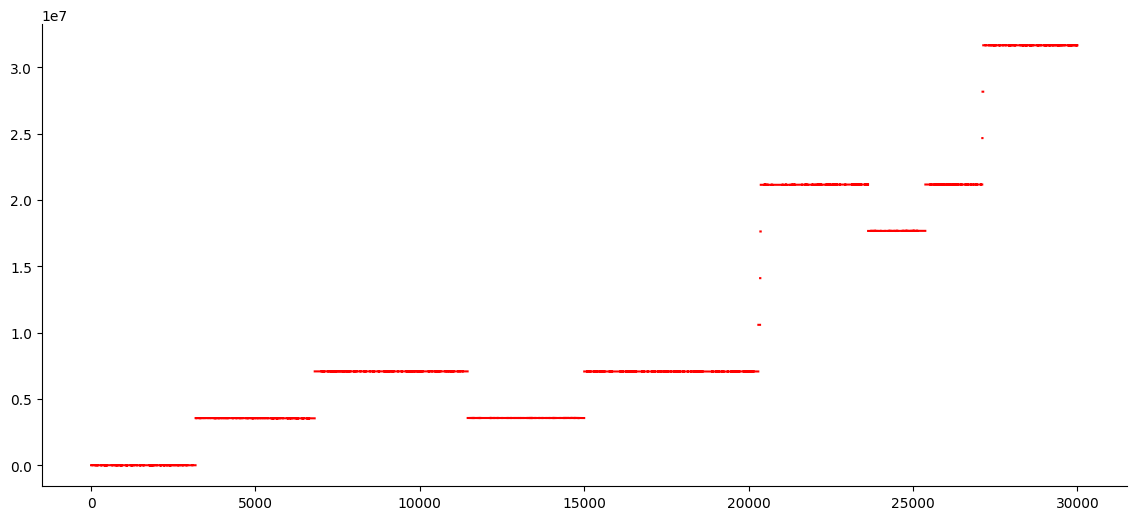

In [ ]:
import matplotlib.pyplot as plt
#df_fairs['PNL_DIFF_1'].plot(kind='line', figsize=(14, 6), title='PNL',label='diff', color='purple')
#plt.gca().spines[['top', 'right']].set_visible(False)
#df_fairs['PNL_DIFF_2'].plot(kind='line', figsize=(14, 6), label='spread', color='orange')
#plt.gca().spines[['top', 'right']].set_visible(False)

df_fairs['PNL_SPREAD_1'].plot(kind='line', figsize=(14, 6), label='PNL_1', color='red')
plt.gca().spines[['top', 'right']].set_visible(False)
"""
df_fairs['PNL_SPREAD_2'].plot(kind='line', figsize=(14, 6), label='PNL_2', color='green')
plt.gca().spines[['top', 'right']].set_visible(False)

df_fairs['PNL_SQUID_INK_RETURNS'].plot(kind='line', figsize=(14, 6), label='PNL_SQUID_INK_RETURNS', color='blue')
"""

In [ ]:
import itertools

def run_backtest(data, underlying, spread_num, bb_window, bb_std, lookback, pop_mean, ema, bb_mult, bb_vol_window, strict):
    # Apply Bollinger Bands and regime detection
    data = boll(data, spread_num, window=bb_window, num_std=bb_std, recent_vol=bb_mult, vol_window=bb_vol_window)
    data[f'REGIME_{spread_num}'] = identify_regime(data, spread_num, pop_mean, lookback, ema=ema)
    data[f'SIGNAL_{spread_num}'] = generate_signals(data, pop_mean, spread_num, strict=strict)
    data[f'POSITION_{spread_num}'] = update_position(data[f'SIGNAL_{spread_num}'])

    # Cash & PnL calculation

    data[f'POSITION_{spread_num}_DIFF'] = data[f'POSITION_{spread_num}'].diff().fillna(0)


    data[f'CASH_{spread_num}'] = -data[f'POSITION_{spread_num}_DIFF'] * data[underlying]
    data[f'CUMULATIVE_CASH_{spread_num}'] = data[f'CASH_{spread_num}'].cumsum()
    data[f'PNL_{spread_num}'] = data[f'CUMULATIVE_CASH_{spread_num}'] + data[f'POSITION_{spread_num}'] * data[underlying]



    """
    data['CASH_'+spread_num] = 0
    data['CASH_'+spread_num] = -data['POSITION_DIFF_'+spread_num] * 2 * data['PICNIC_BASKET1'] + data['POSITION_DIFF_'+spread_num] * 3 * data['PICNIC_BASKET2']
    data['CUMULATIVE_CASH_'+spread_num] = data['CASH_'+spread_num].cumsum()
    data['PNL_'+spread_num] = data['CUMULATIVE_CASH_'+spread_num] + data['POSITION_'+spread_num] * 2 * data['PICNIC_BASKET1'] - data['POSITION_'+spread_num] * 3 * data['PICNIC_BASKET2'] #+ df_fairs['POSITION_2'] * df_fairs['SPREAD_2']
    """

    return data


bb_windows = [100] #, 150, 200, 500]
bb_vol_windows = [5, 15, 30]
bb_mults = [0, 1, 2, 5]
bb_stds = [1.5, 2, 3, 5]
lookbacks = [5, 15, 30, 100] #[30, 50, 100] #, 150, 200] #, 250, 300, 500]
pop_means = [0]#, spread_diff_1_mean]
emas = [0, 1, 2, 5]
stricts = [True, False]


results = []
for bb_window, bb_std, lookback, pop_mean, ema, bb_vol_window, bb_mult, strict in itertools.product(bb_windows, bb_stds, lookbacks, pop_means, emas, bb_vol_windows, bb_mults, stricts):
  data = run_backtest(df_fairs.copy(), 'SQUID_INK', 'SQUID_INK_RETURNS', bb_window, bb_std, lookback, pop_mean, ema, bb_mult, bb_vol_window, strict)
  pnl = data['PNL_SQUID_INK_RETURNS'].iloc[-1]
  returns = data['PNL_SQUID_INK_RETURNS'].diff().dropna()
  sharpe = returns.mean() / returns.std()
  results.append({
        'bb_window': bb_window,
        'bb_std': bb_std,
        'lookback': lookback,
        'pnl': pnl,
        'sharpe': sharpe,
        'pop_mean': pop_mean,
        'ema': ema,
        'bb_vol_window': bb_vol_window,
        'bb_mult': bb_mult,
        'strict': strict
    })

best_result = max(results, key=lambda x: x['pnl'])
print("\nBest Pnl Parameters:")
print(f"Bollinger Bands Window: {best_result['bb_window']}")
print(f"Bollinger Bands Std: {best_result['bb_std']}")
print(f"Lookback: {best_result['lookback']}")
print(f"PNL: {best_result['pnl']}")
print(f"Sharpe: {best_result['sharpe']}")
print(f"Pop mean: {best_result['pop_mean']}")
print(f"EMA: {best_result['ema']}")
print(f"BB Vol Window: {best_result['bb_vol_window']}")
print(f"BB Mult: {best_result['bb_mult']}")
print(f"Strict: {best_result['strict']}")

best_result = max(results, key=lambda x: x['sharpe'])
print("\nBest Sharpe Parameters:")
print(f"Bollinger Bands Window: {best_result['bb_window']}")
print(f"Bollinger Bands Std: {best_result['bb_std']}")
print(f"Lookback: {best_result['lookback']}")
print(f"PNL: {best_result['pnl']}")
print(f"Sharpe: {best_result['sharpe']}")
print(f"Pop mean: {best_result['pop_mean']}")
print(f"EMA: {best_result['ema']}")
print(f"BB Vol Window: {best_result['bb_vol_window']}")
print(f"BB Mult: {best_result['bb_mult']}")
print(f"Strict: {best_result['strict']}")

results = pd.DataFrame(results)
results = results.sort_values(by='pnl', ascending=False)
results


100%|██████████| 29999/29999 [00:01<00:00, 24984.04it/s]
<ipython-input-247-38a12a992569>:46: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std()
100%|██████████| 29999/29999 [00:00<00:00, 54212.38it/s]
<ipython-input-247-38a12a992569>:46: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std()
100%|██████████| 29999/29999 [00:00<00:00, 42218.28it/s]
<ipython-input-247-38a12a992569>:46: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std()
100%|██████████| 29999/29999 [00:00<00:00, 52408.91it/s]
<ipython-input-247-38a12a992569>:46: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std()
100%|██████████| 29999/29999 [00:01<00:00, 24520.19it/s]
<ipython-input-247-38a12a992569>:46: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std()
100%|██████████| 29999/29


Best Pnl Parameters:
Bollinger Bands Window: 100
Bollinger Bands Std: 1.5
Lookback: 30
PNL: 58390.439642437515
Sharpe: 0.04142764708817779
Pop mean: 0
EMA: 0
BB Vol Window: 15
BB Mult: 1

Best Sharpe Parameters:
Bollinger Bands Window: 100
Bollinger Bands Std: 1.5
Lookback: 30
PNL: 58390.439642437515
Sharpe: 0.04142764708817779
Pop mean: 0
EMA: 0
BB Vol Window: 15
BB Mult: 1


<ipython-input-247-38a12a992569>:46: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = returns.mean() / returns.std()


,bb_window,bb_std,lookback,pnl,sharpe,pop_mean,ema,bb_vol_window,bb_mult
203,100,1.5,30,58390.439642,0.041428,0,0,15,1
202,100,1.5,30,58390.439642,0.041428,0,0,15,1
210,100,1.5,30,55814.494119,0.039658,0,0,30,1
211,100,1.5,30,55814.494119,0.039658,0,0,30,1
194,100,1.5,30,53660.073619,0.038151,0,0,5,1
...,...,...,...,...,...,...,...,...,...
433,100,2.0,5,-10432.157254,-0.008641,0,2,5,0
440,100,2.0,5,-10432.157254,-0.008641,0,2,15,0
441,100,2.0,5,-10432.157254,-0.008641,0,2,15,0
426,100,2.0,5,-11364.298930,-0.009737,0,1,30,1


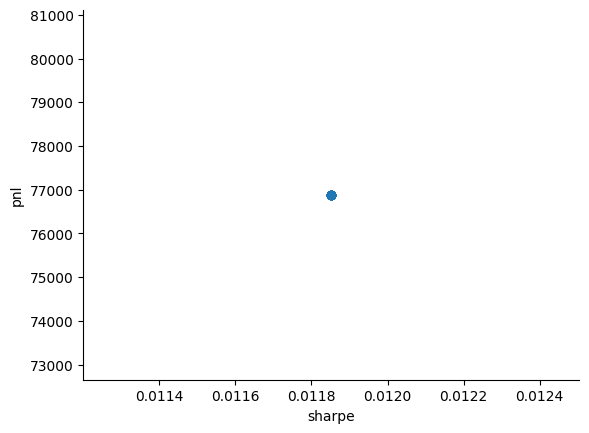

In [ ]:
from matplotlib import pyplot as plt
results.plot(kind='scatter', x='sharpe', y='pnl', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)